# **Case studies**$\def\ket#1{\left|#1\right\rangle}\def\bra#1{\left\langle #1\right|}$

In [1]:
import sys
sys.path.insert(0, "../..") # clue is here

from clue.qiskit import *
from math import log
from numpy import gcd
from random import choice

In this document we present examples of the lumping on quantum circuits from the *draft*. In particular, we will present what it means a lumping on several problems and how to extract the information directly from the lumping. The problems we are going to focus in this document are:

* The **Search algorithm** using Grover's gate.
* The **Order computation** using a multiplication by $x$ module $N$ gate.
* The **Phase estimation** problem using Kitaev's gate based on the multiplication by $x$ module $N$ gate.

## 1. *Search algorithm*

Let $f: \{0,\ldots,2^n-1\} \rightarrow \{0,1\}$ be a boolean function that defines a success criteria for a search. Grover's gate is defined by:
$$G \ket{x} = (-1)^{f(x)} \left(I - 2 \ket{\psi} \bra{\psi}\right)\ket{x}.$$

In the *draft* we shows that the unitary matrix that defines Grover's gate enjoys a lumping when observing the entangled state $\ket{\psi}$. More precisely, since the entangled state can be represented as a linear combination of the *success* state and *failure* state, then CLUE will return a lumping of length 2 that will contain all the information about these two states.

In [59]:
f = lambda p : 0 if p == 0 else 1 if 3**(int(log(p)/log(3))) == p else 0 # looks for powers of 3
print(f"Success search: {[i for i in range(1,256) if f(i) == 1]}")
G(f,4)

Success search: [1, 3, 9, 27, 81]


array([[ 0.875+0.j,  0.125-0.j, -0.125+0.j,  0.125-0.j, -0.125+0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125-0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,
        -0.125+0.j],
       [-0.125+0.j, -0.875+0.j, -0.125+0.j,  0.125-0.j, -0.125+0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125-0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,
        -0.125+0.j],
       [-0.125+0.j,  0.125-0.j,  0.875+0.j,  0.125-0.j, -0.125+0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125-0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,
        -0.125+0.j],
       [-0.125+0.j,  0.125-0.j, -0.125+0.j, -0.875+0.j, -0.125+0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125-0.j,
        -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j, -0.125+0.j,
        -0.125+0.j],
       [-0.125+0.j,  0.125-0.j, -0.125+0.j,  0.125-0.j,  0.875+0.j,
        -0.125+0.j, -0.125+0.j, 

We can apply CLUE to this matrix and the observable given by $\ket{\psi}$:

In [60]:
system = DS_QuantumCircuit(G(f,4))
lumped = system.lumping([SparsePolynomial.from_vector(Psi(2**4), system.variables, system.field)])

New variables:
y0 = (0.25 + 0.0j)*Q_0000 + (0.25 + 0.0j)*Q_0001 + (0.25 + 0.0j)*Q_0010 + (0.25 + 0.0j)*Q_0011 + (0.25 + 0.0j)*Q_0100 + (0.25 + 0.0j)*Q_0101 + (0.25 + 0.0j)*Q_0110 + (0.25 + 0.0j)*Q_0111 + (0.25 + 0.0j)*Q_1000 + (0.25 + 0.0j)*Q_1001 + (0.25 + 0.0j)*Q_1010 + (0.25 + 0.0j)*Q_1011 + (0.25 + 0.0j)*Q_1100 + (0.25 + 0.0j)*Q_1101 + (0.25 + 0.0j)*Q_1110 + (0.25 + 0.0j)*Q_1111
y1 = (-0.120096115353815 + 0.0j)*Q_0000 + (0.520416499866533 + 0.0j)*Q_0001 + (-0.120096115353815 + 0.0j)*Q_0010 + (0.520416499866533 + 0.0j)*Q_0011 + (-0.120096115353815 + 0.0j)*Q_0100 + (-0.120096115353815 + 0.0j)*Q_0101 + (-0.120096115353815 + 0.0j)*Q_0110 + (-0.120096115353815 + 0.0j)*Q_0111 + (-0.120096115353815 + 0.0j)*Q_1000 + (0.520416499866533 + 0.0j)*Q_1001 + (-0.120096115353815 + 0.0j)*Q_1010 + (-0.120096115353815 + 0.0j)*Q_1011 + (-0.120096115353815 + 0.0j)*Q_1100 + (-0.120096115353815 + 0.0j)*Q_1101 + (-0.120096115353815 + 0.0j)*Q_1110 + (-0.120096115353815 + 0.0j)*Q_1111
New initial conditions

As expected, we got 2 macro-states. One of them is $\ket{\psi}$ itself. We should be able to obtain the success and failure states from these two macro-states:

In [61]:
L = lumped.lumping_matrix.to_numpy(dtype=cdouble)
## Computing the reduced echelon form
new_L = [L[0],L[1]]
new_L[1] = L[1] - L[0]*L[1][0]/L[0][0] # creating zeros on the second row
first_nonzero = min([i for i in range(len(new_L[1])) if new_L[1][i] != 0])
new_L[0] = new_L[0] - new_L[1]*new_L[0][first_nonzero]/new_L[1][first_nonzero]
## Comuting the normalized version
new_L = [row/(sqrt(inner_product(row,row))) for row in new_L]
new_L = array([new_L[0],new_L[1]], dtype=cdouble)
new_L

array([[0.2773501 +0.j, 0.        +0.j, 0.2773501 +0.j, 0.        +0.j,
        0.2773501 +0.j, 0.2773501 +0.j, 0.2773501 +0.j, 0.2773501 +0.j,
        0.2773501 +0.j, 0.        +0.j, 0.2773501 +0.j, 0.2773501 +0.j,
        0.2773501 +0.j, 0.2773501 +0.j, 0.2773501 +0.j, 0.2773501 +0.j],
       [0.        +0.j, 0.57735027+0.j, 0.        +0.j, 0.57735027+0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.57735027+0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j]])

In [62]:
## checking the states
states = [[i for i in range(len(row)) if row[i] != 0] for row in new_L]
states

[[0, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15], [1, 3, 9]]

We can see here that thes are the two states: the failure state (first row) and the success state (second row). Once we have splitted the two cases, we could check which one is the failure and the success by evaluating once the oracle $f(\cdot).$

In [63]:
[f(state[0]) for state in states] 

[0, 1]

## 2. *Order finding*

Let $x \in \{2,3,\ldots, N-1\}$. We want to find the order of $x$ module $N$, i.e., find the minimal $r$ such that $x^r = 1 (mod\ N)$. Using the results from the *draft*, we know that for a gate that permorms the multiplication by $x$ module $N$ enjoys a lumping when setting the observable $\ket{1}$. More precisely, the dimension of the lumpin es exactly $r$.

In [64]:
N = 17*13; x = 7
system = DS_QuantumCircuit(U(x,N))
lumped = system.lumping([SparsePolynomial.from_vector([0,1] + (system.size-2)*[0], system.variables, system.field)])

New variables:
y0 = Q_00000001
y1 = Q_10011110
y2 = Q_11010100
y3 = Q_01111101
y4 = Q_01010001
y5 = Q_11001001
y6 = Q_10011011
y7 = Q_10110100
y8 = Q_10011000
y9 = Q_10010100
y10 = Q_10110011
y11 = Q_11010111
y12 = Q_10011101
y13 = Q_00110110
y14 = Q_10000110
y15 = Q_10110001
y16 = Q_01111000
y17 = Q_10101111
y18 = Q_00011001
y19 = Q_11000001
y20 = Q_11011001
y21 = Q_00011111
y22 = Q_00100100
y23 = Q_10100011
y24 = Q_01110110
y25 = Q_01010000
y26 = Q_00101011
y27 = Q_10100100
y28 = Q_00110111
y29 = Q_01000111
y30 = Q_10101000
y31 = Q_00011000
y32 = Q_00100011
y33 = Q_00000101
y34 = Q_01111111
y35 = Q_10110000
y36 = Q_10110111
y37 = Q_10111000
y38 = Q_01111001
y39 = Q_01110000
y40 = Q_00010000
y41 = Q_01100001
y42 = Q_01001101
y43 = Q_00001011
y44 = Q_10111111
y45 = Q_01111010
y46 = Q_00110001
y47 = Q_00000111
New initial conditions:
Lumped system:
y0' = y1
y1' = y2
y2' = y3
y3' = y4
y4' = y5
y5' = y6
y6' = y7
y7' = y8
y8' = y9
y9' = y10
y10' = y11
y11' = y12
y12' = y13
y13' = y14
y14' 

In [65]:
x**lumped.size % N

1

We can now conclude the factorization algorithm after using this information:

In [66]:
guess = gcd(N, x**(lumped.size//2)+1); guess

17

## 3. *Phase Estimation*

In this problem, we are assume that we know a quantum gate $U$ that has a known eigenvector $u$. Since we are working with quantum states and the matrices are unitary, this means that the eigenvalues must be complex numbers of modulus one. Hence, they are of the form $e^{2\pi i \phi}$, where $\phi$ is called the phase of the eigenvalue.

In this problem we try to estimate with $n$ bits the phase $\phi$ by writing 
$$\tilde{\phi} = 0.\phi_{n-1}\cdots\phi_0 = \frac{\phi_{n-1}}{2} + \ldots + \frac{\phi_0}{2^n}.$$

Kitaev circuit is the case for estimating $\phi_{n-1}$, it can be reused to obtain further bits or it can be recombined as in Figure 5.3 (see Nielsen-CHuang book) to obtain all bits at once. In the *draft* , we discuss two lumping cases: the first is when taking $\ket{j}\ket{u}$, obtaining a lumping of size 2 (i.e., we can simulate $K$ with 1 q-bit). The second case is when we consider the entangled state
$$\left[\frac{\ket{0} - \ket{1}}{2}\right]\ket{u}$$

Let us fix $U$ to be defined as in Section 2 (i.e., the circuit that multiplies numbers $y \in [0,\ldots,N-1]$ by a fixed number $x$:

In [2]:
x = 11; N = 16
U(x,N)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.

These are the eigenvectors for this matrix:

In [3]:
from numpy.linalg  import eig
vals, vects = eig(U(x,N))

Let us consider the following eigenvector

In [4]:
u = vects[:,2].conjugate(); u

array([-0.        +0.j, -0.        +0.j,  0.70710678+0.j, -0.        +0.j,
       -0.        +0.j, -0.        +0.j,  0.70710678-0.j, -0.        +0.j,
       -0.        +0.j, -0.        +0.j, -0.        +0.j, -0.        +0.j,
       -0.        +0.j, -0.        +0.j, -0.        +0.j, -0.        +0.j])

Now, let's see if we can compute the lumpings with this eigenvector:

In [5]:
system = DS_QuantumCircuit(K(U(x,N)))
obs = [SparsePolynomial.from_vector(kron([1,0], u), system.variables, CC)] # |0> |u>

In [6]:
lumped = system.lumping(obs)

New variables:
y0 = (0.707106781186547 + 0.0j)*Q_00010 + (0.707106781186548 + 0.0j)*Q_00110
New initial conditions:
Lumped system:
y0' = y0


In [7]:
compare(matmul(U(x,N), u), u)

True

We can see that we obtained a lumping of size 1. This means that the eigenvalue of $u$ is exactly $1$. Let us take another eigenvector (now checking the eigenvalue is not 1):

In [8]:
valid_vals = [i for i in range(len(vals)) if vals[i].round(10) not in (0.,1.,-1.)]
if len(valid_vals) == 0:
    print("All eigenvalues were 1, -1 or 0")
ind = choice(valid_vals)
l = vals[ind]; u = vects[:,ind]
print(f"({l=}) u ->\n", u.round(5))
obs0 = [SparsePolynomial.from_vector(kron([1,0], u), system.variables, CC)] # |0> |u>
obs1 = [SparsePolynomial.from_vector(kron([0,1], u), system.variables, CC)] # |1> |u>

(l=(5.551115123125783e-17+1.0000000000000007j)) u ->
 [ 0. +0.j  -0. -0.5j  0. +0.j   0.5+0.j   0. +0.j   0. +0.j   0. +0.j
  0. +0.j   0. +0.j  -0. +0.5j  0. +0.j  -0.5-0.j   0. +0.j   0. +0.j
  0. +0.j   0. +0.j ]


In [11]:
lumped0 = system.lumping(obs0, print_reduction=False); lumped0.size

2

In [12]:
lumped1 = system.lumping(obs1, print_reduction=False); lumped1.size

2

Finally, we can check the special case that always provide a lumping of dimension 1:

In [13]:
obs2 =  [SparsePolynomial.from_vector(kron([1/sqrt(2),-1/sqrt(2)], u), system.variables, CC)] # ((1/sqrt(2))(|0> - |1>)) |u>
lumped2 = system.lumping(obs2, print_reduction=False); lumped2.size

1

**WARNING!!** We could not get back the lumping of dimension one. Check out why.

### Using measures on Kitaev circuit to estimate eigenvalue

Using the fact that measuring a 0 or a 1 in the first q-bit is given by $\mathbb{P}(0) = \frac{1+\cos(2\pi \phi))}{2}$, we could measure several times the output and get the value of $\phi$ by computing the arccos:
$$\phi = \frac{\arccos\left(2\mathbb{P}(0) - 1\right)}{2\pi}.$$

However, this formula has several values that solves it. Namely, since $\cos(\theta) = \cos(-\theta) = \cos(2\pi -\theta)$, we have 2 possible values for $\phi$:
$$
    \phi_1 = \frac{\arccos\left(2\mathbb{P}(0) - 1\right)}{2\pi},\qquad 
    \phi_2 = \frac{2\pi - \arccos\left(2\mathbb{P}(0) - 1\right)}{2\pi}.
$$

We can simply check for these 4 cases which one is the correct one by looking how $U$ acts over $u$.

In [14]:
circuit = K(U(x,N))
entry = kron([1,0], u) # |0> |u>

phi ->  [0.25007353 1.74992647]
phase ->  0.25007352958632423
CPU times: user 23.3 s, sys: 40.3 ms, total: 23.3 s
Wall time: 23.3 s


(array([249597.,      0.,      0., 250172.,      0.,      0., 250119.,
             0.,      0., 250112.]),
 array([ 1. ,  3.6,  6.2,  8.8, 11.4, 14. , 16.6, 19.2, 21.8, 24.4, 27. ]),
 <BarContainer object of 10 artists>)

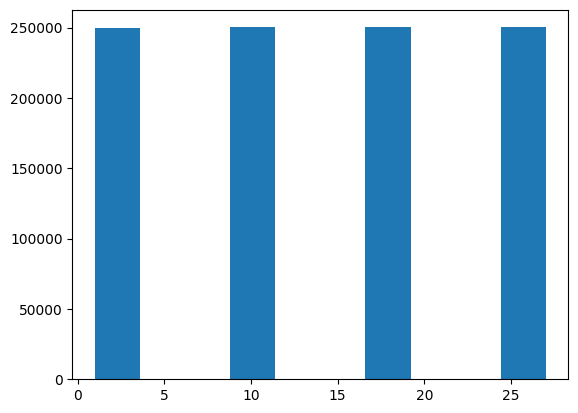

In [36]:
%%time
from matplotlib.pyplot import hist
from numpy import arccos, argmin, tile
from numpy.linalg import norm
count = 0; size = len(entry); total = 1_000_000
out_vector = matmul(circuit, entry)
measures = []
measuring = lambda : measure(out_vector)

for _ in range(total):
    measured = measuring()
    measures.append(measured)
    if measured < size//2: # we measure a zero
        count += 1

prob_0 = count/total
# Main formula: arccos(2*P*(0) - 1) / 2*pi
phi = array([arccos(2 * prob_0 - 1) / (2*pi), 2-arccos(2 * prob_0 - 1) /(2*pi)]); print("phi -> ", phi)
phase = phi[argmin(norm((outer(exp(2j*pi*phi), u) - tile(matmul(U(x,N), u), (2,1))), axis = 1))]
print("phase -> ", phase)
hist(measures);

We can try and use a reduced model to measure the same thing using a smaller model:

phi ->  [0.25009358 1.74990642]
phase ->  0.2500935831119307
CPU times: user 27.5 s, sys: 50.5 ms, total: 27.5 s
Wall time: 27.5 s


(array([249328.,      0.,      0., 250378.,      0.,      0., 249443.,
             0.,      0., 250851.]),
 array([ 1. ,  3.6,  6.2,  8.8, 11.4, 14. , 16.6, 19.2, 21.8, 24.4, 27. ]),
 <BarContainer object of 10 artists>)

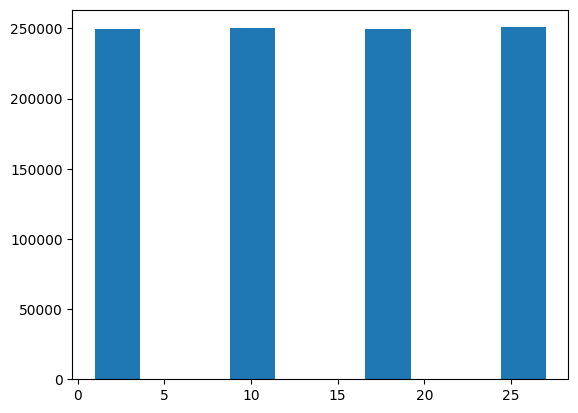

In [37]:
%%time
from numpy import arccos, argmin, tile
from numpy.linalg import norm
count = 0; size = len(entry); total = 1_000_000
out_vector = array(lumped0.derivative(_,1,0))
L = lumped0.lumping_matrix.to_numpy(dtype=cdouble)
measures = []
measuring = lambda : measure(L[measure(out_vector)])

for _ in range(total):
    measured = measuring()
    measures.append(measured)
    if measured < size//2: # we measure a zero
        count += 1

prob_0 = count/total
# Main formula: arccos(2*P*(0) - 1) / 2*pi
phi = array([arccos(2 * prob_0 - 1) / (2*pi), 2-arccos(2 * prob_0 - 1) /(2*pi)]); print("phi -> ", phi)
phase = phi[argmin(norm((outer(exp(2j*pi*phi), u) - tile(matmul(U(x,N), u), (2,1))), axis = 1))]
print("phase -> ", phase)
hist(measures);